## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp, ExpSquaredCenteredKernel, ExpSquaredKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#import ROOT as r
#import warnings
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

## Section 1: including and visualizing 13 TeV dataset

In [3]:
xvalO = np.load("xvalO.npy")
yvalO = np.load("yvalO.npy")
xerrO = np.load("xerrO.npy")
xlowO = np.load("xlowO.npy")
xval = np.load("xval.npy")
yval = np.load("yval.npy")
xerr = np.load("xerr.npy")

toyList = np.load("toyList.npy")
lumiToyDict = np.load("lumiToyList.npy")
meanGPnom = np.load("initialGPfit.npy")
fixedHyperparams = np.load("fixedHyperparams.npy")
sigToys = np.load("signalToys.npy")
sigToysO = np.load("signalToysO.npy")

standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]

In [4]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

In [13]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  #1./(t/sqrts)

In [5]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                #pval = 1.-r.TMath.Gamma(nD+1.,nB)
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                #pval = pval = r.TMath.Gamma(nD,nB)
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                #zval = math.sqrt(2.)*r.TMath.ErfInverse(prob)
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
                #print "crap"
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2



def simpleLogPoisson(x, par):
    if x < 0: 
        #print "crap"
        return np.inf
    elif (x == 0): return -1.*par
    else:
        #lnpoisson = x*np.log(par)-par-r.TMath.LnGamma(x+1.)
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson
    
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys

def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### This set has all bins that equal 0 removed. These 0 points really bias the GP

## GP SIGNAL FIGURE 8

In [6]:
def makePrettyPlots_sb(xs_long, xs_short, ys_long, ys_short, yd_short, bkgs, bkgsigs,xlow_short, title, ymax = 2e5):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs_long, ys_long, marker='o', ls='None', yerr = np.sqrt(ys_long), c='black', markersize=10, label="data+signal")
    bkg1Plot, = ax1.plot(xs_short, bkgs, color='g', linewidth=3.0, label="bkg only")
    bkg2Plot, = ax1.plot(xs_long, bkgsigs, color='b', linewidth=3.0, label="bkg+signal")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=20)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_short, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow_short,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    #print h1[:]
    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    #ax2.set_ylim([-2, 8])

    zvals_2, chi2_2 = calcSignificance(ys_long, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax3.set_ylabel('Significance', fontsize=20)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    
    print len(yd_short), len(bkgs)
    zvals_3, chi2_3 = calcSignificance(yd_short, bkgs)
    print "chi2 bkg+signal", chi2_3
    h3 = Hist(xlow_short,markersize=0)
    for x in range(len(zvals_3)):
        if zvals_3[x] == np.inf or zvals_3[x] == -np.inf: h3[x] = 20
        else: h3[x] = zvals_3[x]  
    h3.fillstyle = 'solid'
    h3.fillcolor = 'red'
    h3.linecolor = 'black'
    h3.linewidth = 1
    h3.Draw("histX0")
    rplt.bar(h3, xerr=None, yerr=None, axes=ax4)
    ax4.axhline(0, color='black', lw=1)
    ax4.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax4.set_ylabel('Significance', fontsize=20)
    ax4.set_xscale('log')
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    ax4.set_ylim([-5, 5])
    ax4.set_xlim([1000, 7500])

    ax4.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax4.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax4.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    
def makePrettyPlots_signalOnly(xs, ys, bkgs, title, ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color='g', linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

    
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  

    h1.fillstyle = 'solid'
    h1.fillcolor = 'blue'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

In [10]:
def model_gp(params, t, xerr=xerr): 
    #global xerr
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

In [19]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    #while not passedFit and numRetries < 5:

    for i in range(100):
        init0 = np.random.random() * 500.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
        '''
        if fit[0]['is_valid']: 
            passedFit=True
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1 
        '''

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [21]:
chi_GP_sig={}
chi_GP_bkg={}
chi_GP_sb={}
aa={}
mm={}
ww={}
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    chi_GP_sig[m]=[]
    chi_GP_bkg[m]=[]
    chi_GP_sb[m]=[]
    aa[m]=[]
    mm[m]=[]
    ww[m]=[]
    for itoy, toy in enumerate(toyList[:100]):
        if itoy%10 ==0: print itoy
        
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        xtoylow = list(xtoy-xtoyerr/2.)

        signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy + signalTemplate

        signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy + signalTemplateO

        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        #print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_3param(xvalO,(p0,p1,p2),xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_3param(xtoy, (p0,p1, p2), xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

    
        zvalsig, chi2sig = calcSignificance(signalTemplate, mu2)
        zvalsb, chi2sb = calcSignificance(ydataO, meanGP)
        zvalbkg, chi2bkg = calcSignificance(ytoy, mu1)
        chi_GP_sig[m].append(chi2sig) 
        chi_GP_sb[m].append(chi2sb) 
        chi_GP_bkg[m].append(chi2bkg) 
        


   # label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
   # makePrettyPlots_sb(xvalO, xtoy, ydataO, ydata, ytoy, mu1, meanGP, xtoylow, label)
    
   # label="Signal only: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
   # makePrettyPlots_signalOnly(xtoy, signalTemplate, mu2, label, n)
        

parameters (1500, 2000, 250)
0
10


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


20
30
40
50
60
70
80
90
parameters (750, 2500, 250)
0
10
20
30
40
50
60
70
80
90
parameters (200, 3000, 250)
0
10
20
30
40
50
60
70
80
90
parameters (75, 3500, 250)
0
10
20
30
40
50
60
70
80
90
parameters (50, 4000, 250)
0
10
20
30
40
50
60
70
80
90
parameters (25, 4500, 250)
0
10
20
30
40
50
60
70
80
90
parameters (20, 5000, 250)
0
10
20


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


30
40
50
60
70
80
90
parameters (15, 5500, 250)
0
10
20
30
40
50
60
70
80
90
parameters (15, 6000, 250)
0
10
20
30
40
50
60
70
80
90


In [23]:
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    

parameters (1500, 2000, 250)
15067.0643645 2036.92513952 242.884387149
parameters (750, 2500, 250)
5074.67093663 2516.29421701 257.851477881
parameters (200, 3000, 250)
709.448613717 3210.98923313 225.746718275
parameters (75, 3500, 250)
726.029940549 3562.88758486 191.053994807
parameters (50, 4000, 250)
1944.14443984 3868.12108777 183.744751774
parameters (25, 4500, 250)
3422.21628296 3719.65437962 150.635175257
parameters (20, 5000, 250)
4551.46933484 3785.34237168 164.28300932
parameters (15, 5500, 250)
1090.14827872 4336.76433285 194.476684844
parameters (15, 6000, 250)
1892.18368669 4374.46668927 202.411164576


In [24]:
class logLike_gp_fitgpsig2:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, A1, w1):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            #print "hi", model_gp((p0,p1,p2), self.x, self.xerr)
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr) - sig_model(self.x, A1, mass, w1, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit2(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0, 0)
    for i in range(100):
        init0 = np.random.random() * 500.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 500.
        #init4 = np.random.random() * 4000.
        init4 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  A = init0, mass = init1, tau = init2, A1 = init3, w1 = init4,
                  error_A = 100., error_mass = 10., error_tau = 5., error_A1 = 100., error_w1 = 5.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_A1 = (1, 1e5), 
                  limit_w1 = (100, 500))
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args
    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [ ]:
chi_GP_sig2={}
chi_GP_bkg2={}
chi_GP_sb2={}
aa2={}
mm2={}
ww2={}
print fixedHyperparams
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    chi_GP_sig2[m]=[]
    chi_GP_bkg2[m]=[]
    chi_GP_sb2[m]=[]
    aa2[m]=[]
    mm2[m]=[]
    ww2[m]=[]
    for itoy, toy in enumerate(toyList[:10]):
        if itoy%10 ==0: print itoy
        
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        xtoylow = list(xtoy-xtoyerr/2.)

        signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy + signalTemplate

        signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy + signalTemplateO

        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig2(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit2(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        
        A, mass, tau, A1, w1 = best_fit_new 
        print "A, mass, tau", A, mass, tau, A1, w1

        #A, mass, tau = best_fit_new 
        aa2[m].append(A1)
        mm2[m].append(mass)
        ww2[m].append(w1)
        #print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr)-sig_model(xtoy, A1, mass, w1, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_3param(xvalO,(p0,p1,p2),xerrO) + sig_model(xvalO, A1, mass, w1, xerrO)
      #  meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
      #  meanGP = meanGPp + model_3param(xvalO,(p0,p1,p2),xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_3param(xtoy, (p0,p1, p2), xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + sig_model(xtoy, A1, mass, w1, xtoyerr)

    
        zvalsig, chi2sig = calcSignificance(signalTemplate, mu2)
        zvalsb, chi2sb = calcSignificance(ydataO, meanGP)
        zvalbkg, chi2bkg = calcSignificance(ytoy, mu1)
        chi_GP_sig2[m].append(chi2sig) 
        chi_GP_sb2[m].append(chi2sb) 
        chi_GP_bkg2[m].append(chi2bkg) 
        


   # label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
   # makePrettyPlots_sb(xvalO, xtoy, ydataO, ydata, ytoy, mu1, meanGP, xtoylow, label)
    
   # label="Signal only: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
   # makePrettyPlots_signalOnly(xtoy, signalTemplate, mu2, label, n)
        

[  2.58152631e+07   1.62331670e+02   1.19749544e-01  -1.33472298e+02
   2.18750064e+00   1.64801807e-02   8.44386637e+00  -5.22509390e+00]
parameters (1500, 2000, 250)
0
A, mass, tau 1.00090878371 1988.45718149 100.000024697 1634.10945274 253.731937409


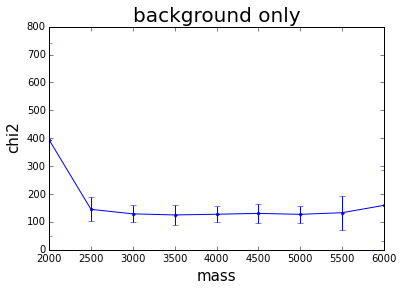

In [47]:

plt.title("background only", fontsize=20)
plt.errorbar(msignals,[chi_GP_bkg[i][0] for i in range(len(chi_GP_bkg))],yerr = [chi_GP_bkg[i][2] for i in range(len(chi_GP_bkg))], marker=".", linestyle="-")
plt.xlabel('mass', fontsize=15)
plt.ylabel('chi2', fontsize=15)
#plt.set_xscale('log')
#plt.set_yscale('log')


#plt.errorbar([1900, 2400, 2800, 3300, 3800, 4300, 4700, 5300],[chi_GP_sig[i][0] for i in range(len(chi_GP_sig)-1)],yerr = [chi_GP_sig[i][2] for i in range(len(chi_GP_sig)-1)], marker=".", linestyle="-")
#plt.xlabel('mass', fontsize=15)
#plt.ylabel('chi2', fontsize=15)

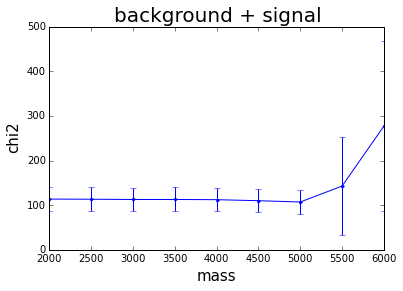

In [48]:
plt.title("background + signal", fontsize=20)
plt.errorbar(msignals,[chi_GP_sb[i][0] for i in range(len(chi_GP_sb))],yerr = [chi_GP_sb[i][2] for i in range(len(chi_GP_sb))], marker=".", linestyle="-")
plt.xlabel('mass', fontsize=15)
plt.ylabel('chi2', fontsize=15)